In [1]:
import numpy as np
from commpy.utilities  import upsample
from optic.comm.modulation import modulateGray
from optic.dsp.core import pulseShape, signal_power
from optic.models.devices import photodiode, ring_modulator

try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt

# Test OOK Ring Resonator Response

Average power of the modulated optical signal [mW]: 0.238 mW
Average power of the modulated optical signal [dBm]: -6.233 dBm


c:\anaconda\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\anaconda\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


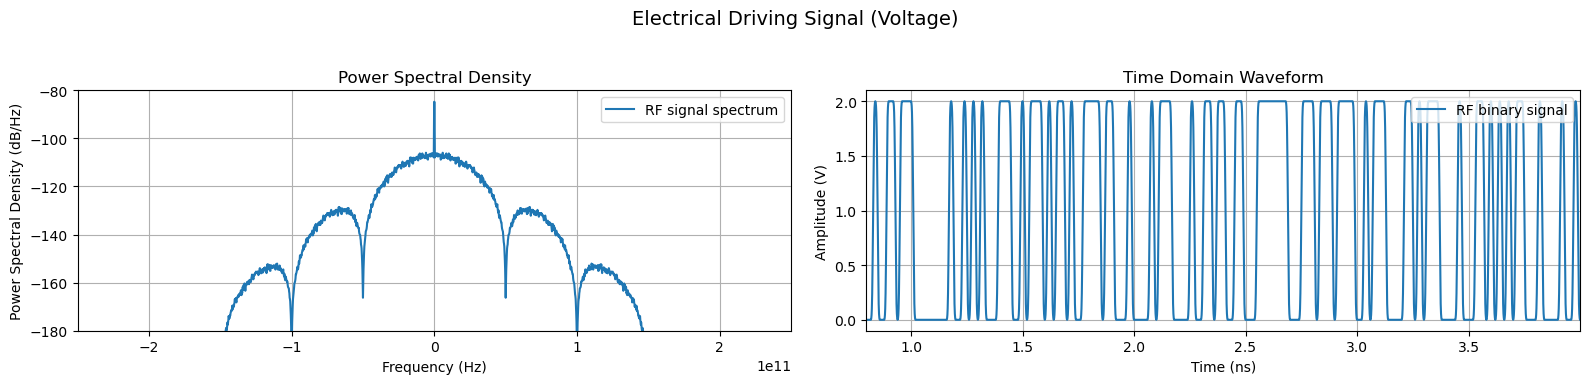

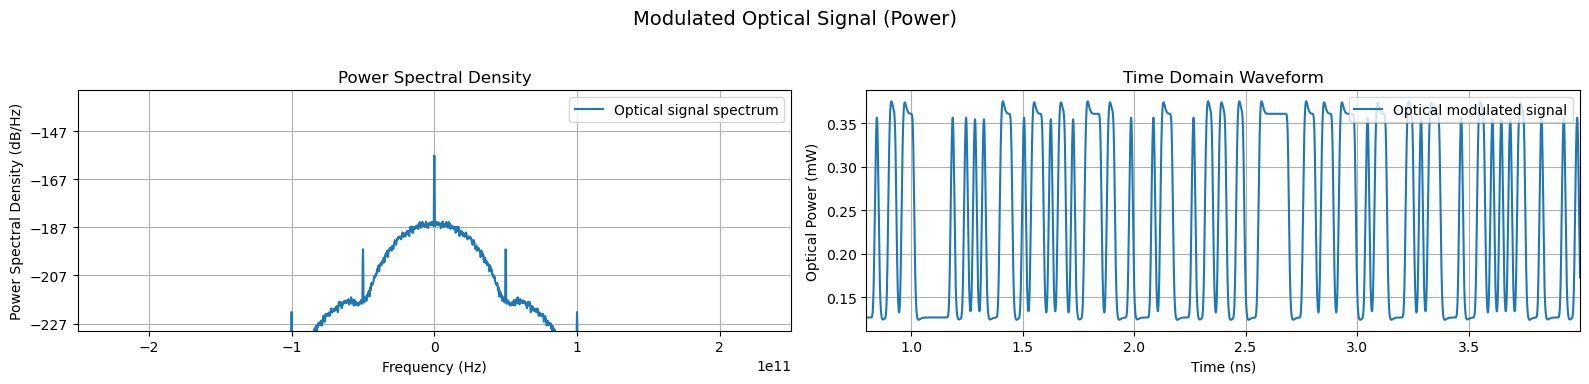

In [11]:
# --- Define Ring Parameters (Matching the previous example script) ---
ring_radius = 10e-6
ring_loss_dB_m = 8000
ring_kappa_power = 0.20 # Power coupling fraction
ring_resonant_wavelength = 1550e-9
ring_n_eff = 2.4
ring_ng = 4.2
ring_tuning_m_per_V = 100e-12
ring_dn_dV = ring_n_eff * ring_tuning_m_per_V/(1550e-9)
# RC filter parameters from original class example
ring_rc_filter_enabled = True
ring_rc_time_constant = 5e-12 # 4 ps

SpS = 64      # samples per symbol
M = 2         # order of the modulation format (OOK/BPSK mapped to PAM)
Rs = 50e9     # Symbol rate (for OOK case Rs = Rb)
Fs = Rs * SpS   # Sampling frequency
Ts = 1 / Fs     # Sampling period

Pi_dBm = 0          
Pi = dBm2W(Pi_dBm)  
Ai = np.sqrt(Pi)    

bitsTx = np.random.randint(2, size=int(1e4))

symbTx_pam = modulateGray(bitsTx, M, 'pam')

symbTx_voltage = symbTx_pam + 1 # scale from [-1,1] to [0,2] for NRZ

symbolsUp = upsample(symbTx_voltage, SpS)

pulse = pulseShape('nrz', SpS)
pulse = pulse / max(abs(pulse)) # Normalize pulse amplitude (although NRZ is usually 1)

sigTx = firFilter(pulse, symbolsUp) # This is the voltage waveform V(t)

input_field_waveform = np.full(len(sigTx), Ai, dtype=complex)
output_field = ring_modulator(
    input_waveform=input_field_waveform,
    dt=Ts,
    radius=ring_radius,
    resonant_wavelength=ring_resonant_wavelength,
    n_eff=ring_n_eff,
    ng=ring_ng,
    dn_dV=ring_dn_dV,
    loss_dB_m=ring_loss_dB_m,
    kappa_power=ring_kappa_power,
    rc_filter_enabled=ring_rc_filter_enabled,
    rc_time_constant=ring_rc_time_constant,
    wavelength_offset=-75e-12,
    voltage_waveform=sigTx     # The shaped electrical signal
)

avg_power_W = signal_power(output_field)
print(f'Average power of the modulated optical signal [mW]: {avg_power_W / 1e-3:.3f} mW')
print(f'Average power of the modulated optical signal [dBm]: {10 * np.log10(avg_power_W / 1e-3):.3f} dBm') # Note: dBm requires 1mW reference

num_symbols_plot = 160 # Number of symbols to plot
start_symbol = 40
interval = np.arange(SpS * start_symbol, SpS * (start_symbol + num_symbols_plot))
t = interval * Ts / 1e-9 # Time in ns

fig1, axs1 = plt.subplots(1, 2, figsize=(16, 4)) # Increased height slightly
fig1.suptitle('Electrical Driving Signal (Voltage)', fontsize=14)

axs1[0].set_title('Power Spectral Density')
axs1[0].psd(sigTx, Fs=Fs, NFFT=16 * 1024, sides='twosided', label='RF signal spectrum')
axs1[0].set_xlim(-5 * Rs, 5 * Rs) # Show x-axis in GHz
axs1[0].set_xlabel('Frequency (Hz)')
axs1[0].set_ylim(-180, -80) # Adjust ylim if needed
axs1[0].legend(loc='upper right')
axs1[0].grid(True)

axs1[1].set_title('Time Domain Waveform')
axs1[1].plot(t, sigTx[interval], label='RF binary signal', linewidth=1.5)
axs1[1].set_ylabel('Amplitude (V)')
axs1[1].set_xlabel('Time (ns)')
axs1[1].set_xlim(min(t), max(t))
axs1[1].legend(loc='upper right')
axs1[1].grid(True)
fig1.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap


fig2, axs2 = plt.subplots(1, 2, figsize=(16, 4)) # Increased height slightly
fig2.suptitle('Modulated Optical Signal (Power)', fontsize=14)

output_power_W = np.real(output_field * np.conj(output_field))

axs2[0].set_title('Power Spectral Density')
axs2[0].psd(output_power_W, Fs=Fs, NFFT=16 * 1024, sides='twosided', label='Optical signal spectrum')
axs2[0].set_xlim(-5 * Rs, 5 * Rs) # Show x-axis in GHz
axs2[0].set_xlabel('Frequency (Hz)')
axs2[0].set_ylim(-230, -130) # Adjust ylim if needed
axs2[0].legend(loc='upper right')
axs2[0].grid(True)

output_power_mW = output_power_W / 1e-3
axs2[1].set_title('Time Domain Waveform')
axs2[1].plot(t, output_power_mW[interval], label='Optical modulated signal', linewidth=1.5)
axs2[1].set_ylabel('Optical Power (mW)')
axs2[1].set_xlabel('Time (ns)')
axs2[1].set_xlim(min(t), max(t))
axs2[1].legend(loc='upper right')
axs2[1].grid(True)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

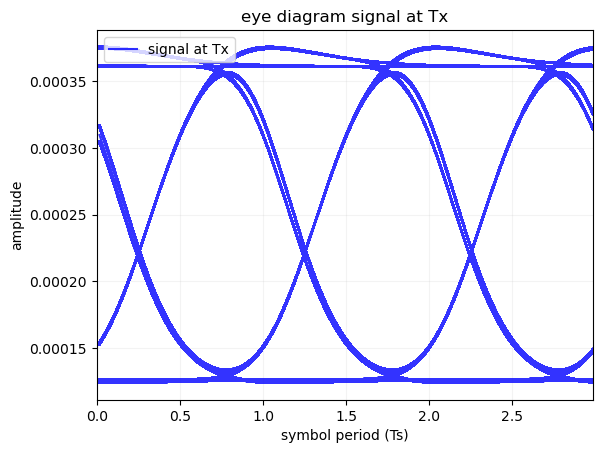

In [12]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs

I_Tx = photodiode(output_field, paramPD) # transmitted signal
discard = 100
eyediagram(I_Tx[discard:-discard], I_Tx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fast')